# Basic Usage

This notebook will guide users through `opticam_new`'s basic usage by reducing some synthetic data. First, we need to generate the data:

In [1]:
import create_test_data

create_test_data.main()  # generate some test data

Creating test data...


100%|██████████| 100/100 [00:00<00:00, 371177.35it/s]


The function called above generates 100 images for each of OPTICAM's three cameras. These images are stored in a new `Data` directory, which will be created in the current working directory. Each image has a 1 s exposure, and uses the maximum 8x8 binning (to reduce file size for this example). The observation times of the test data correspond to January 1st 2024, and the three filters used are "g", "i", and "r".

The first step in reducing any OPTICAM data is to initialise a `Reducer()` object. We will store any output files in the `Reduced` directory, which will be created in the current working directory if it does not exist:

In [2]:
from opticam_new import Reducer

reducer = Reducer(
    data_directory='Data/',  # path to the simulated data
    out_directory='Reduced/',  # path to where output will be saved
    show_plots=True,
    )

[OPTICAM] Scanning data directory:   0%|          | 0/300 [00:00<?, ?it/s]

[OPTICAM] Done.
[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] Read g-band catalog from file.
[OPTICAM] Read r-band catalog from file.
[OPTICAM] Read i-band catalog from file.


After initialising a `Reducer()` object, you will see the image binnings and the filters used. If more than one binning value is detected, an error will be raised and the binning value for each file will be logged in `out_directory/diag/binnings.json`. Similarly, an error will be raised if more than three filters are detected, with the filter for each file being logged in `out_directory/diag/filters.json`. In this case, there were no problems with our data, and so we can proceed with reduction.

After initialising a `Reducer()` object, the next step is usually to create source catalogs for each camera. Ideally, there would be a single catalog for all three cameras, however, field-of-view and pixel-scale differences between them make this difficult. As such, it is best to define catalogs for each camera independently.

Initialising catalogs requires aligning each camera's images, and so this method is where the alignment parameters can be tweaked. When observing with OPTICAM, the telescope will move to counteract the rotation of the Earth; as such, the only alignment required should be small x, y translations. By default, images will be aligned using the `translation` `transform_type` (x, y translation), using the three brightest sources in the field as references. However, `euclidean` (translation and rotation) and `similarity` (translation, rotation, and scaling) are also available. The number of reference sources can also be changed, though 2 is the minimum for `euclidean` and `similarity`, 1 is the minimum for `translation`. I general, I would suggest setting the number of reference sources above the minimum since more reference sources will be more robust against source misidentification.

Let's initialise the source catalogs using the default parameters:

In [3]:
reducer.initialise_catalogs()

[OPTICAM] Catalogs already exist. To overwrite, set overwrite to True.


In [4]:
reducer.create_gifs(keep_frames=False)

[OPTICAM] g-band GIF already exists. To overwrite, set overwrite to True.
[OPTICAM] r-band GIF already exists. To overwrite, set overwrite to True.
[OPTICAM] i-band GIF already exists. To overwrite, set overwrite to True.


We can see that six sources have been identified in each of the three sets of images. In this example, the source labelling is consistent across the catalogs because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogs, and so care must be taken when performing differential photometry that the same sources are being used for each filter (more on this later). After initialising our catalogs, a number of diagnostic plots are also generated. By default, these plots are not shown but are saved to the `out_directory/diag` directory. To display these plots in the console, users can set `show_diagnostic_plots=True` in `reducer.initialise_catalogs()`.

With our catalogs defined, we can now perform aperture photometry. In this example, we will leverage all of the different photometry methods currently available: 'aperture', 'annulus', 'normal', and 'optimal'. For more information about the different photometries, see the dedicated photometry tutorial. For 'aperture' and 'annulus' photometries, we need to call the `forced_photometry()` method using `phot_type='both'`:

In [5]:
reducer.forced_photometry(phot_type='both')

[OPTICAM] Performing forced photometry on g-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving g-band light curves: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


[OPTICAM] Performing forced photometry on r-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving r-band light curves: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


[OPTICAM] Performing forced photometry on i-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving i-band light curves: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


`forced_photometry` is quite quick, and uses the alignment transformations to infer source positions in each image. If the alignments are good, this will work well. However, wide apertures are needed to ensure that the source is captured if the alignments are less than perfect, and so the signal-to-noise ratio for these photometries will generally be worse than those of 'normal' and 'optimal'.

For 'normal' and 'optimal' photometries, we need to call the `photometry()` method (again using `phot_type='both'`):

In [6]:
reducer.photometry(phot_type='both')

Photometries available via the `photometry()` method require fitting for the source positions in each image, making this method generally more time consuming than `forced_photometry()`. Moreover, faint sources may undetectable in some images, depending on the value of 'threshold' specified when instancing a `Reducer()` object, meaning the number of data points in a resulting light curve may have fewer than the nominal number of data points. The number of detections for each source can be seen in the plots produced by `photometry()` for each band. As we can see above, all sources have the nomincal number of detections, shown by the dashed red line.

In this example, we will assume that source 2 is our target of interest, and will use all other sources for comparisons. In practise, the choice of comparison star(s) is cruical for obtaining a quality final light curve. Even for stars that are known to be constant emitters, it is important to consider things like where the source is on the CCD, since the systematics can vary with posiiton, as well as the source colour. To choose suitable comparison sources, it is most instructive to inspect the raw light curves and choose those that look most similar to and/or are physically close to the target source. However, this is beyond the scope of this tutorial.

Let's now produce a relative light curve for source 2 using the 'annulus' light curves. First, however, we need to initialise a `Photometer()` object. When initialising a `Photometer()` object, we need to pass the directory path to the reduced data created by `Reducer()`:

['g-band', 'r-band', 'i-band']


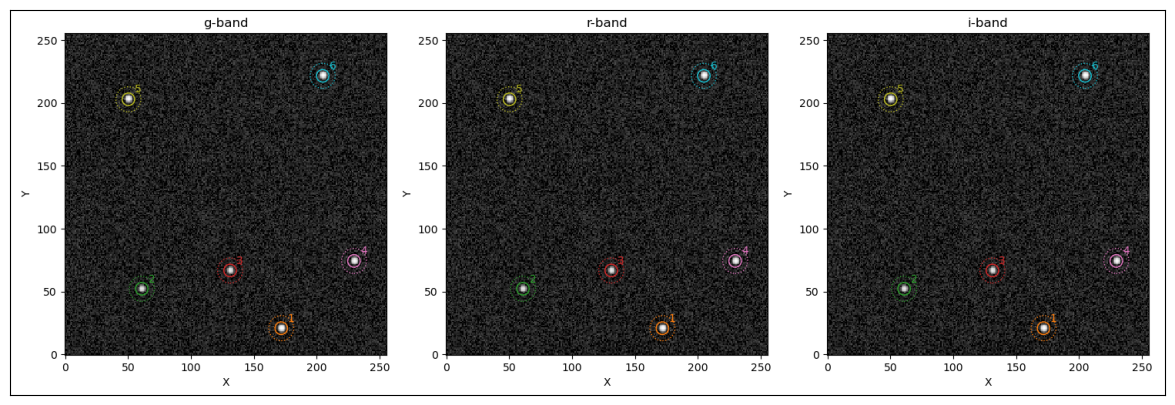

In [7]:
from opticam_new import Photometer

photometer = Photometer(
    out_directory='Reduced',
    )

When initialising a `Photometer()` object, the source catalogs are output for convenience (since reduction may be separated from analysis). We can now create our relative light curve:

r-band 2 [1, 3, 4, 5, 6]
i-band 2 [1, 3, 4, 5, 6]


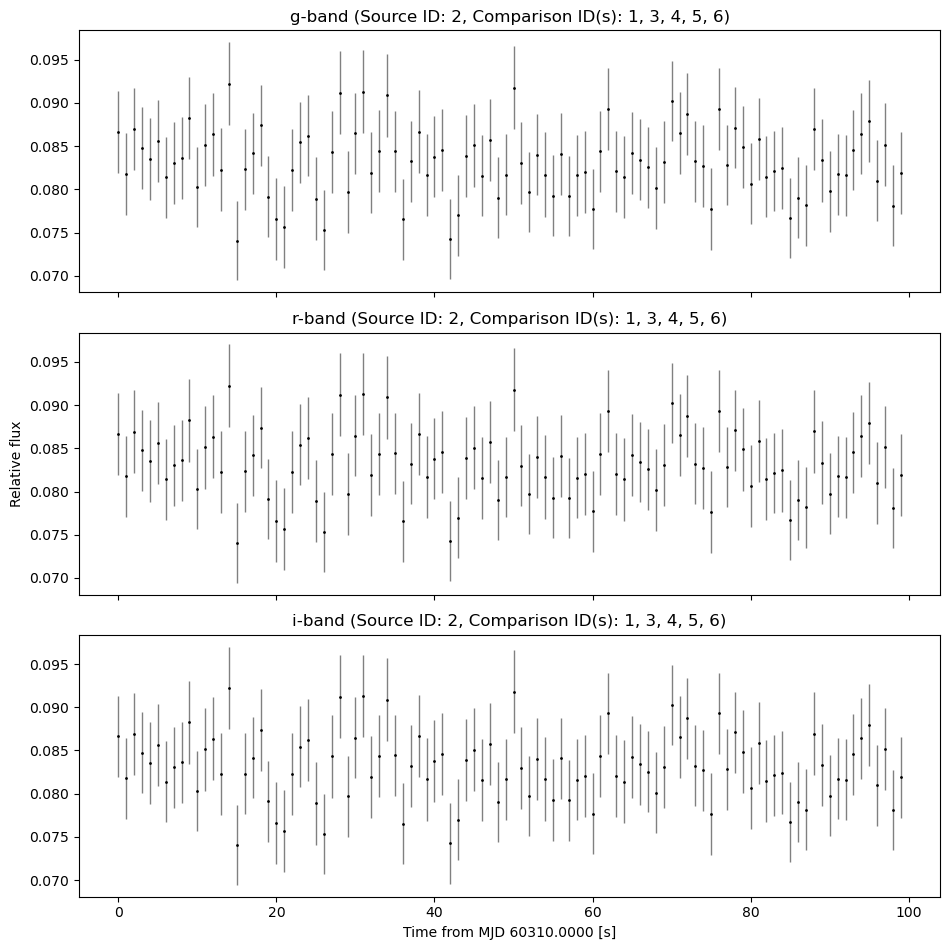

In [8]:
target = 2
comparisons = [1, 3, 4, 5, 6]

analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='annulus', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. These plots are saved in `out_directory/relative_light_curves/diag`, and will be displayed unless `show_diagnostics` is set to `False`. For this example, I have set `show_diagnostics` to `False` for simplicity, since I know all the comparison sources are good in this case (there are no position-dependent systematics or colour variations in the sources).

The `get_relative_light_curve()` method can also match sources across filters by setting `match_other_cameras` to `True`. However, this can misidentify sources, so care should be taken to check the correct sources are identified when `match_other_cameras = True`. In this case, we can see that the identified sources are correct, and so we don't have to manually create relative light curves for each filter.

When relative light curves are created, an `Analyser` object is returned. This analyser object can be used to perform a few basic timing analyses, such as computing periodograms and phase folding. In this case, we'll take a look at the periodograms for each camera and see if there's anything interesting there:

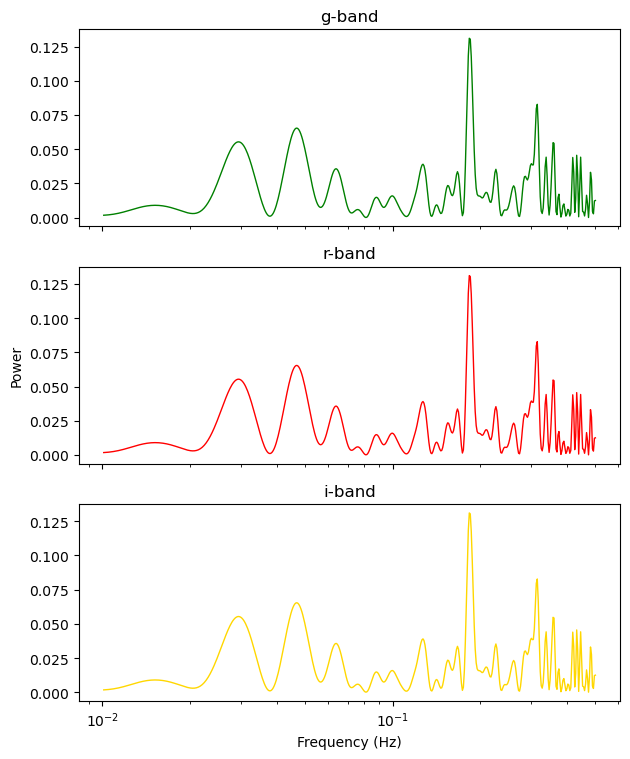

In [9]:
frequencies, periodograms = analyser.lomb_scargle(scale='log', show_plot=True)

As we can see, there is a strong signal around 0.2 Hz. Let's see if we get a better signal-to-noise ratio using the 'optimal' photometry light curves:

r-band 2 [1, 3, 4, 5, 6]
i-band 2 [1, 3, 4, 5, 6]


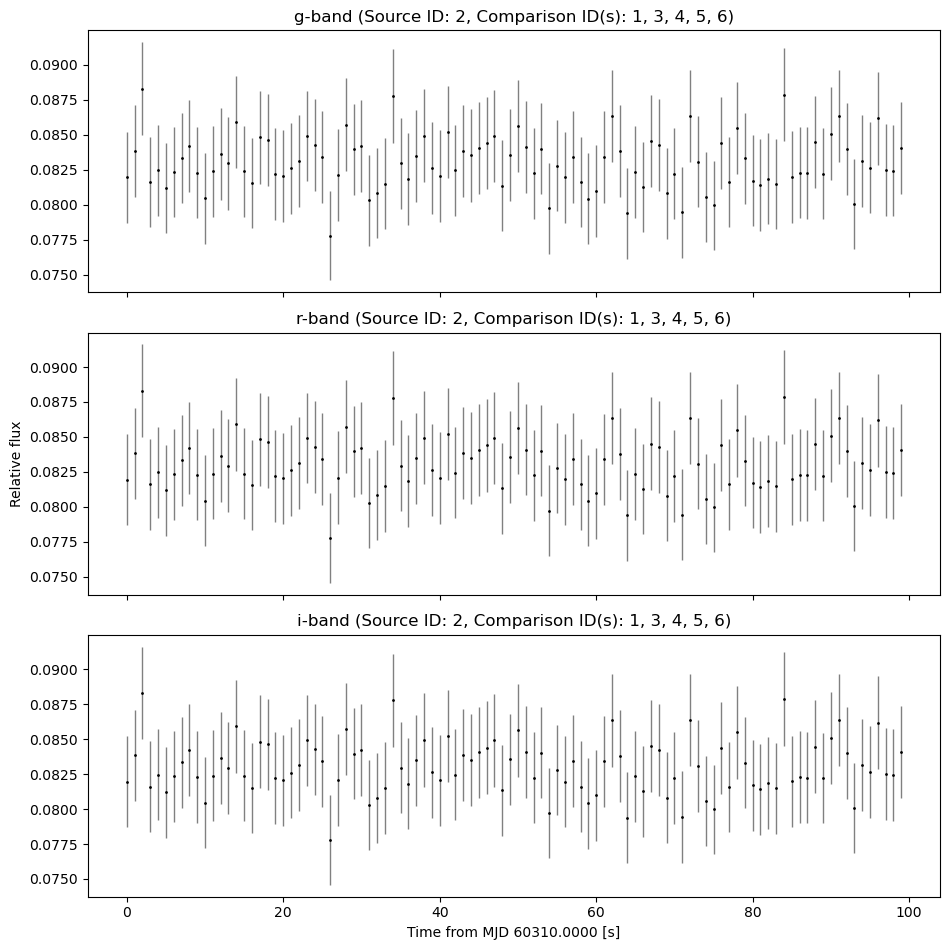

In [10]:
analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='optimal', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

Now the periodicity can be seen by eye. Let's check the new periodogram:

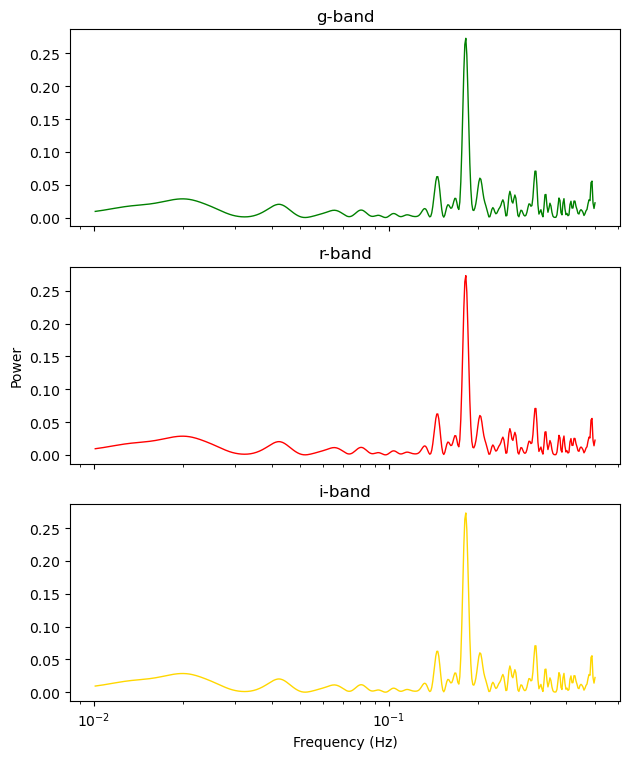

In [11]:
frequencies, powers = analyser.lomb_scargle(scale='log', show_plot=True)

In [12]:
import numpy as np
import astropy.units as u

f = frequencies[np.argmax(powers['g-band'])] * u.Hz

print(f)

0.1823417103470343 Hz


As we can see, the signal is much stronger. Let's also try phase folding to see the pulse shape:

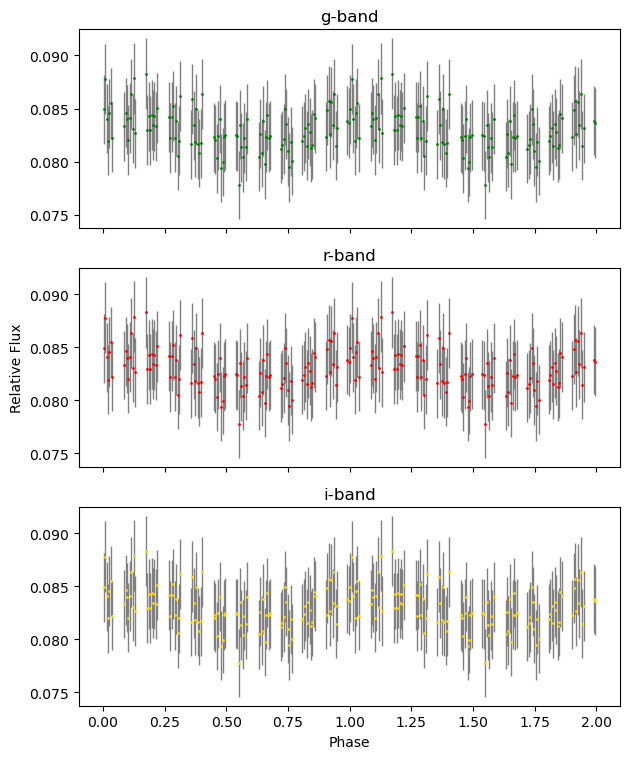

In [13]:
# NOTE: the period must be an astropy unit object (e.g. u.s, u.min, u.hour, u.day) to ensure the correct units are used
phases = analyser.phase_fold(period=1/f)

In [14]:
print(phases)

{'g-band': 0     0.808961
1     0.991303
2     0.173644
3     0.355986
4     0.538328
        ...   
95    0.131423
96    0.313765
97    0.496107
98    0.678449
99    0.860790
Name: BDT, Length: 100, dtype: float64, 'r-band': 0     0.808961
1     0.991303
2     0.173644
3     0.355986
4     0.538328
        ...   
95    0.131423
96    0.313765
97    0.496107
98    0.678449
99    0.860790
Name: BDT, Length: 100, dtype: float64, 'i-band': 0     0.808961
1     0.991303
2     0.173644
3     0.355986
4     0.538328
        ...   
95    0.131423
96    0.313765
97    0.496107
98    0.678449
99    0.860790
Name: BDT, Length: 100, dtype: float64}


The large error bars somewhat obscure the variations. Let's try phase binning instead:

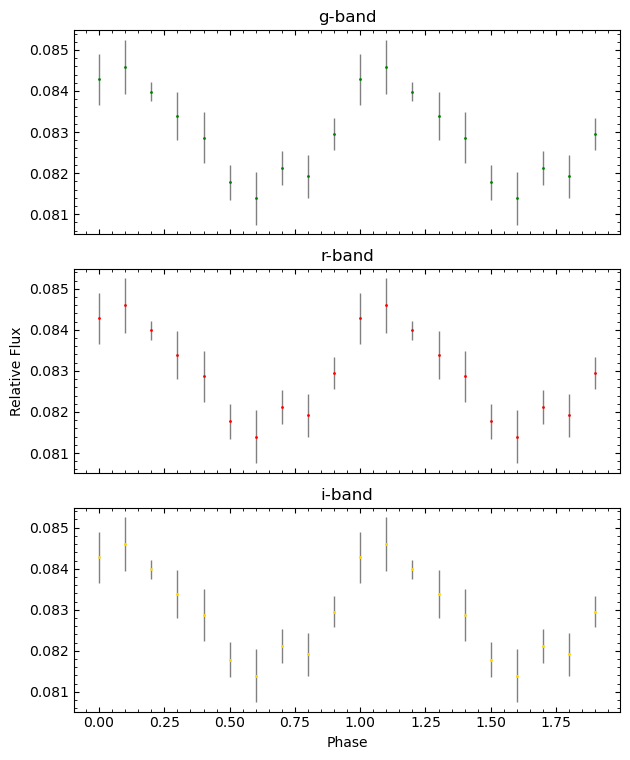

In [15]:
results = analyser.phase_bin(period=1/f)

In [16]:
print(results)

{'g-band': {'phase': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'flux': array([0.08428381, 0.08459339, 0.08398676, 0.08339107, 0.08286602,
       0.08177882, 0.08139081, 0.08211402, 0.0819194 , 0.08295101]), 'flux error': array([0.00062188, 0.0006586 , 0.00023021, 0.00058517, 0.00062789,
       0.00042713, 0.00064512, 0.00041317, 0.00052667, 0.00038101])}, 'r-band': {'phase': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'flux': array([0.08428381, 0.08459339, 0.08398676, 0.08339107, 0.08286602,
       0.08177882, 0.08139081, 0.08211402, 0.0819194 , 0.08295101]), 'flux error': array([0.00062188, 0.0006586 , 0.00023021, 0.00058517, 0.00062789,
       0.00042713, 0.00064512, 0.00041317, 0.00052667, 0.00038101])}, 'i-band': {'phase': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'flux': array([0.08428381, 0.08459339, 0.08398676, 0.08339107, 0.08286602,
       0.08177882, 0.08139081, 0.08211402, 0.0819194 , 0.08295101]), 'flux error': array([0.00062

The variations are much clearer now. We could use these plots to identify rotation/orbital periods, phase lags, etc., but this is beyond the scope of this tutorial.

That concludes the basic usage tutorial for `opticam_new`! For more specific documentation on each stage of the pipeline, see the dedicated tutorials.